In [54]:
## IMPORTS

# BASE
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

# MACHINE LEARNING
from sklearn.model_selection import train_test_split, learning_curve
# Models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
## Hyperparameter Tuning
from scipy.stats import randint
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, TimeSeriesSplit

# PROJECT MODULES
import models_utils

In [55]:
## HYPERPARAMETER TUNING

def perform_search(model, params, X_train, y_train, X_test, y_test, search_type='random'):
    tscv = TimeSeriesSplit(n_splits=3)
    
    if search_type == 'random':
        search = RandomizedSearchCV(model, param_distributions=params, n_iter=200, scoring='neg_mean_absolute_percentage_error', n_jobs=-1, cv=tscv)
    elif search_type == 'grid':
        search = GridSearchCV(model, param_grid=params, scoring='neg_mean_absolute_percentage_error', n_jobs=-1, cv=tscv)
    else:
        raise ValueError("Invalid search_type. Use 'random' or 'grid'.")
    
    model_search = search.fit(X_train, y_train)

    print('Best hyperparameters are: ' + str(model_search.best_params_))
    print('Best score is: ' + str(model_search.best_score_))

    model = model_search.best_estimator_
    model.fit(X_train, y_train)
    
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    mae = mean_absolute_error(y_test, pred)
    mape = mean_absolute_percentage_error(y_test, pred)
    print('MSE:', mse)
    print('MAE:', mae)
    print('MAPE:', mape)
    
    train_sizes, train_scores, test_scores = learning_curve(model, X_train, y_train, cv=tscv, scoring='neg_mean_absolute_percentage_error')

    return model, train_sizes, train_scores, test_scores

In [56]:
## CHARTS and UTILS

tscv = TimeSeriesSplit(n_splits=3)

def get_model_feature_importances(model, feature_names):
    feature_importances = model.feature_importances_
    feature_importances_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances_df.sort_values(by='importance', ascending=False, inplace=True)
    feature_importances_df.set_index('feature', inplace=True, drop=True)
    return feature_importances_df


def plot_learning_curve(model, X, y, cv, train_sizes=np.linspace(0.1, 1.0, 10), scoring='neg_mean_squared_error'):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv, train_sizes=train_sizes, scoring=scoring, n_jobs=-1
    )

    train_scores_mean = -np.mean(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)

    plt.figure(figsize=(8, 4))
    plt.plot(train_sizes, train_scores_mean, label='Training error')
    plt.plot(train_sizes, test_scores_mean, label='Validation error')
    plt.xlabel('Training examples')
    plt.ylabel(f'Negative {scoring.capitalize()}')  # Adjust the ylabel based on your scoring metric
    plt.title('Learning Curve')
    plt.legend(loc='best')
    plt.show()

def plot_feature_importances(feature_importances, feature_names):
    # Sort feature importances in descending order
    sorted_idx = np.argsort(feature_importances)[::-1]
    # Plot the top 20 most important features
    plt.figure(figsize=(10, 6))
    plt.bar(range(20), feature_importances[sorted_idx][:20], align='center')
    plt.xticks(range(20), feature_names[sorted_idx][:20], rotation=45)
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.title('Top 20 Feature Importances')
    plt.show()

def remove_low_importance_features(feature_importances, threshold=0.01):
    # Assuming feature_importances is a pandas Series
    selected_features = feature_importances[feature_importances >= threshold].index
    return selected_features

In [57]:
## OPEN FILE

lots = pd.read_csv('../clean-files/catalogo_artworks_info.csv', index_col=0)
lots.drop(columns=['Error', '0', '0.1', '0.2', '0.3', '0.4'], inplace=True)

# Fix Year Column
# lots['Year'] = lots.index
# lots['Year'] = lots['Year'].astype(float).astype(int)
# lots['Year'] = lots['Year'].fillna(lots['Década'])
# lots['Year'] = lots['Year'].fillna(lots['Year'].mean())
# lots['Year'] = lots['Year'].astype(int)

print(lots.shape)
lots.columns

(22265, 21)


Index(['artist_link', 'Descrição', 'Fonte de Pesquisa', 'Data da Pesquisa',
       'Type', 'Século', 'Artist', 'Título', 'url', 'Década', 'img_url',
       'Medium', 'Height (cm)', 'Width (cm)', 'Area (cm²)', 'Price (BRL)',
       'Price (USD)', 'Price (BRL/cm²)', 'Medium_type', 'Sold',
       'Year of sale'],
      dtype='object')

In [58]:
## SELECT ARTISTS

artists = lots['Artist'].value_counts()
artists = artists[artists > 500]
print(artists)
artists = artists.index
lots = lots[lots['Artist'].isin(artists)]

Artist
Di Cavalcanti (1897-1976)                                     2937
Aldemir Martins                                               2257
Candido Portinari (1903-1962)                                 2008
Milton Dacosta                                                1908
Antônio Bandeira (1922-1967)                                  1703
Tarsila do Amaral                                             1478
Djanira da Motta e Silva                                      1368
Alberto Guignard - Alberto da Veiga Guignard                  1081
Maria Leontina Franco Da Costa                                1074
Ibere Camargo - Iberê Camargo                                 1039
José Pancetti - Giuseppe Gianinni Pancetti - Jose Pancetti    1035
Cicero Dias - Cícero Dias                                      606
Cildo Meireles (1948)                                          606
Alfredo Volpi                                                  587
Annita Catarina Malfatti - Anita Malfatti - Anita Malfa

In [59]:
# CLEAN ARTIST NAMES

artists_list_raw = ['Di Cavalcanti (1897-1976)', 'Aldemir Martins',
       'Candido Portinari (1903-1962)', 'Milton Dacosta',
       'Antônio Bandeira (1922-1967)', 'Tarsila do Amaral',
       'Djanira da Motta e Silva',
       'Alberto Guignard - Alberto da Veiga Guignard',
       'Maria Leontina Franco Da Costa', 'Ibere Camargo - Iberê Camargo',
       'José Pancetti - Giuseppe Gianinni Pancetti - Jose Pancetti',
       'Cicero Dias - Cícero Dias', 'Cildo Meireles (1948)', 'Alfredo Volpi',
       'Annita Catarina Malfatti - Anita Malfatti - Anita Malfati',
       'Ismael Nery']

artists_list_clean = [
                'Di Cavalcanti',
                'Aldemir Martins',
                'Candido Portinari',
                'Milton Dacosta',
                'Antônio Bandeira',
                'Tarsila do Amaral',
                'Djanira',
                'Alberto Guignard',
                'Maria Leontina',
                'Iberê Camargo',
                'José Pancetti',
                'Cícero Dias',
                'Cildo Meireles',
                'Alfredo Volpi',
                'Anita Malfatti',
                'Ismael Nery']

mapping_dict = dict(zip(artists_list_raw, artists_list_clean))

# Replace raw names with clean names in the 'Artist' column
lots['Artist'] = lots['Artist'].replace(mapping_dict)

,artist_link,Descrição,Fonte de Pesquisa,Data da Pesquisa,Type,Século,Artist,Título,url,Década,...,Medium,Height (cm),Width (cm),Area (cm²),Price (BRL),Price (USD),Price (BRL/cm²),Medium_type,Sold,Year of sale
Year,,,,,,,,,,,,,,,,,,,,,
NaN,https://www.catalogodasartes.com.br/cotacao/ar...,"Estudo para o painel ""Descobrimento do Brasil""...",Leilão James Lisboa 20 e 21 de Março de 2013,20/03/2013,Pinturas,NaN,Candido Portinari,Descobrimento do Brasil,https://www.catalogodasartes.com.br/obra/PPUtt/,50.0,...,Desenho a grafite sobre papel,81.0,100.0,8100.0,600000.0,303030.30,74.074074,desenho,True,2013
NaN,https://www.catalogodasartes.com.br/cotacao/ar...,"São Francisco Grafite s/ papel, 58 x 90 cm, as...",Leilão Canvas 10 de Novembro de 2015,10/11/2015,Pinturas,NaN,Candido Portinari,São Francisco,https://www.catalogodasartes.com.br/obra/GBAPcz/,40.0,...,Grafite sobre papel,90.0,58.0,5220.0,218500.0,57651.72,41.858238,desenho,False,2015
NaN,https://www.catalogodasartes.com.br/cotacao/ar...,"CANDIDO PORTINARI - “Homem”, Gravura em metal ...",Leilão Lordello 31 do 05 e 01 do 06 de 2022,31/05/2022,Pinturas,NaN,Candido Portinari,Homem,https://www.catalogodasartes.com.br/obra/DeGBBPU/,NaN,...,Gravura em metal,7.5,14.2,106.5,2700.0,572.03,25.352113,reprodução,True,2022
1940.0,https://www.catalogodasartes.com.br/cotacao/ar...,Atestado de autenticidade do Projeto Portinari...,Bel Galeria de Arte - Leilão novembro de 2007,22/11/2007,Pinturas,20.0,Candido Portinari,Paisagem RJ,https://www.catalogodasartes.com.br/obra/GUUzc/,40.0,...,Óleo sobre Tela,72.0,60.0,4320.0,700000.0,355329.95,162.037037,pintura,False,2007
1939.0,https://www.catalogodasartes.com.br/cotacao/ar...,"PORTINARI, CANDIDO (1902-1962) - Praça Ensolar...",Leilão Canvas 09 e 10 de Novembro de 2021,09/11/2021,Pinturas,20.0,Candido Portinari,Praça Ensolarada,https://www.catalogodasartes.com.br/obra/PPzGAt/,30.0,...,Aquarela sobre papel,17.0,14.0,238.0,42800.0,7795.99,179.831933,pintura,True,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1988,https://www.catalogodasartes.com.br/cotacao/ar...,Esta obra entrou em pregão com lance inicial d...,Leilão Aloísio Cravo 19 de abril de 2010.,19/04/2010,Pinturas,20.0,Aldemir Martins,Paisagem,https://www.catalogodasartes.com.br/obra/UUtcz/,80.0,...,Acrílica sobre tela,81.0,60.0,4860.0,20000.0,10526.32,4.115226,pintura,True,2010
1987,https://www.catalogodasartes.com.br/cotacao/ar...,Cartão dia dos namorados - Nanquim - Aquarela ...,Leilão Cia Paulista 02 e 03 de Outubro de 2018,03/10/2018,Pinturas,20.0,Aldemir Martins,Cartão dia dos namorados,https://www.catalogodasartes.com.br/obra/cBzPcz/,80.0,...,Nanquim aquarelado sobre cartão,50.0,71.0,3550.0,1000.0,259.74,0.281690,pintura,False,2018
NaN,https://www.catalogodasartes.com.br/cotacao/ar...,Aldemir Martins - nanquim e guache sobre papel...,Leilão Sérgio Altit 26 de junho de 2018,26/06/2018,Pinturas,NaN,Aldemir Martins,Briga de Galo,https://www.catalogodasartes.com.br/obra/APtBBU/,NaN,...,Nanquim e guache sobre papel,70.0,52.0,3640.0,30000.0,7957.56,8.241758,pintura,False,2018


In [60]:
## DROP OUTLIERS (BRL/cm² > 0.9 percentile and < 0.1 percentile)

# for each medium_type, remove outliers: lots with price / area > 0.9 percentile
for medium_type in lots['Medium_type'].unique():
    medium_type_lots = lots[lots['Medium_type'] == medium_type]
    medium_type_lots = medium_type_lots[medium_type_lots['Price (BRL/cm²)'] < medium_type_lots['Price (BRL/cm²)'].quantile(0.8)]
    medium_type_lots = medium_type_lots[medium_type_lots['Price (BRL/cm²)'] > medium_type_lots['Price (BRL/cm²)'].quantile(0.2)]
    print(medium_type, len(medium_type_lots))
    lots = pd.concat([lots[lots['Medium_type'] != medium_type], medium_type_lots])

desenho 2704
reprodução 2995
pintura 6559
outro 905


In [61]:
## DISCARD 'OTHER' MEDIUM TYPES
lots = lots[lots['Medium_type'] != 'outro']
# lots = lots[lots['Medium_type'] == 'pintura']

In [62]:
## GET DF TO MODEL
lots = lots[['Artist', 'Width (cm)', 'Height (cm)', 'Year of sale', 'Price (BRL)', 'Medium_type']]
X_train, X_test, y_train, y_test = models_utils.get_df_to_model(lots) # WHY ARE ALL 'desenho' GETTING LOST HERE??

feature_names = X_test.columns
print(feature_names)

shape of lots_to_model (before split): (12258, 6)
model features: 20
Index(['Artist_Aldemir Martins', 'Artist_Alfredo Volpi',
       'Artist_Anita Malfatti', 'Artist_Antônio Bandeira',
       'Artist_Candido Portinari', 'Artist_Cildo Meireles',
       'Artist_Cícero Dias', 'Artist_Di Cavalcanti', 'Artist_Djanira',
       'Artist_Iberê Camargo', 'Artist_Ismael Nery', 'Artist_José Pancetti',
       'Artist_Maria Leontina', 'Artist_Milton Dacosta',
       'Artist_Tarsila do Amaral', 'Height (cm)', 'Medium_type_pintura',
       'Medium_type_reprodução', 'Width (cm)', 'Year of sale'],
      dtype='object')


Best hyperparameters are: {'n_estimators': 50, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_depth': 9}
Best score is: -0.6025700896920251
MSE: 709099764.3145437
MAE: 10082.893863996176
MAPE: 0.48806802645878916


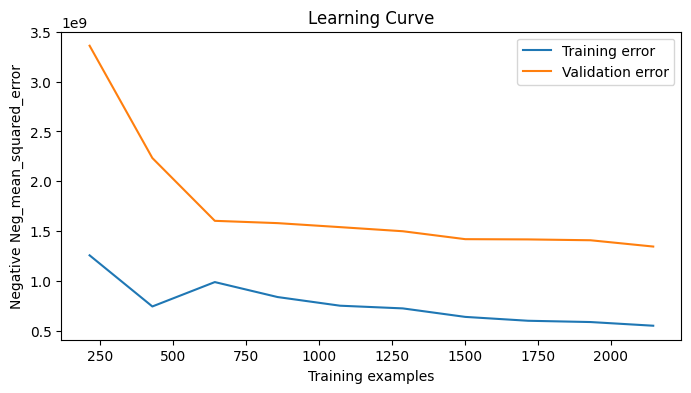

,importance
feature,
Width (cm),6.368142e-01
Artist_Di Cavalcanti,1.202296e-01
Height (cm),9.799454e-02
Medium_type_pintura,6.078275e-02
Year of sale,2.714041e-02
Artist_José Pancetti,1.467900e-02
Artist_Iberê Camargo,1.392342e-02
Artist_Candido Portinari,7.310042e-03
Artist_Cícero Dias,6.060652e-03


In [63]:
# Random Forest
rf = RandomForestRegressor()
rf_params = {
    'n_estimators': np.arange(10, 110, step=20),
     'max_depth': np.arange(2, 10, step=1),
     'min_samples_split': np.arange(2, 10, step=1),
     'min_samples_leaf': np.arange(2, 10, step=1),
}

rf_model, rf_train_sizes, rf_train_scores, rf_test_scores = perform_search(rf, rf_params, X_train, y_train, X_test, y_test, search_type='random')
rf_feature_importances = rf_model.feature_importances_

plot_learning_curve(rf_model, X_train, y_train, cv=tscv)
rf_feature_importances_df = get_model_feature_importances(rf_model, feature_names)
rf_feature_importances_df

In [64]:
## Better setup so far (removed outliers and medium_type == 'outro', artists with > 300 lots)

# Best hyperparameters are: {'n_estimators': 70, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 9}
# Best score is: -776975725.5247191
# MSE: 1213232227.0454812
# MAE: 8760.363494589017
# MAPE: 0.4852745256498374

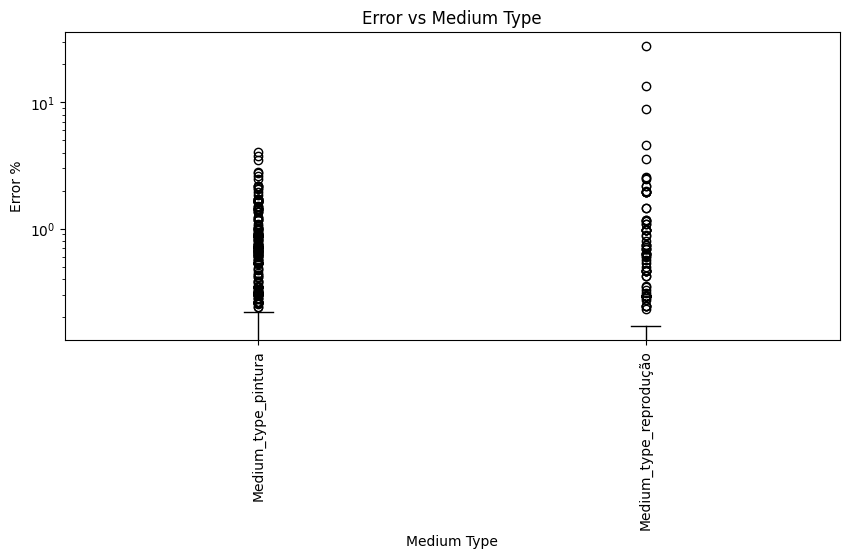

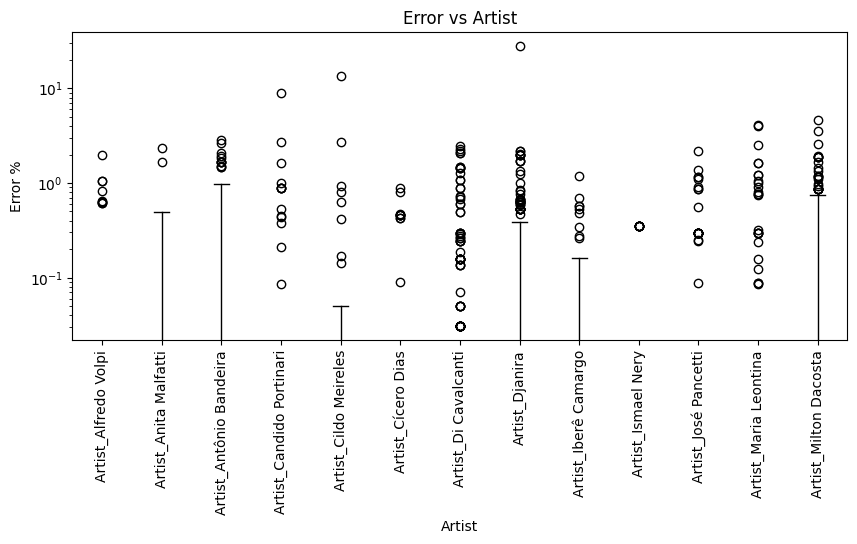

In [65]:
lots_copy = models_utils.get_predicted_price_and_error(X_test, y_test, rf_model)
medium_types = ['Medium_type_pintura', 'Medium_type_reprodução'] #, 'desenho']
artists = lots_copy.columns[1:-10]

models_utils.plot_error_by_columns(lots_copy, medium_types, 'Medium Type')
models_utils.plot_error_by_columns(lots_copy, artists, 'Artist')

In [66]:
## Analyse lots with highest error

lots_copy.sort_values(by='Error %', ascending=False, inplace=True)
lots_copy.head(10)

,Artist_Aldemir Martins,Artist_Alfredo Volpi,Artist_Anita Malfatti,Artist_Antônio Bandeira,Artist_Candido Portinari,Artist_Cildo Meireles,Artist_Cícero Dias,Artist_Di Cavalcanti,Artist_Djanira,Artist_Iberê Camargo,...,Artist_Tarsila do Amaral,Height (cm),Medium_type_pintura,Medium_type_reprodução,Width (cm),Year of sale,Predicted Price,Actual Price,Error,Error %
Year,,,,,,,,,,,,,,,,,,,,,
NaN,False,False,False,False,False,False,False,False,True,False,...,False,65.0,False,True,81.0,2015,35996.195964,1200.0,34796.195964,27.996830
1985.0,False,False,False,False,False,True,False,False,False,False,...,False,63.0,False,True,97.0,2013,27823.316427,1800.0,26023.316427,13.457398
NaN,False,False,False,False,True,False,False,False,False,False,...,False,109.0,False,True,127.0,2013,32513.061829,3000.0,29513.061829,8.837687
NaN,False,False,False,False,False,False,False,False,False,False,...,False,195.0,False,True,102.0,2011,47550.393206,7200.0,40350.393206,4.604221
1966,False,False,False,False,False,False,False,False,False,False,...,False,16.0,False,False,24.0,2011,8609.225938,1400.0,7209.225938,4.149447
1950.0,False,False,False,False,False,False,False,False,False,False,...,False,16.5,True,False,10.0,2007,8431.366848,1400.0,7031.366848,4.022405
1941,False,False,False,False,False,False,False,False,False,False,...,False,35.0,True,False,18.0,2013,29234.718013,5050.0,24184.718013,3.789053
1996,True,False,False,False,False,False,False,False,False,False,...,False,23.3,False,True,16.5,2014,390.689601,70.0,320.689601,3.581280
1942.0,False,False,False,False,False,False,False,False,False,False,...,False,40.0,True,False,50.0,2020,80105.301671,14500.0,65605.301671,3.524504


In [67]:
## TRAINING MODEL WITH SELECTED FEATURES (feature importance > 0.01)

# rf_feature_importances_df = get_model_feature_importances(rf_model, feature_names)
# rf_feature_importances_df
# selected_features = remove_low_importance_features(rf_feature_importances_df, threshold=0.01)
# X_train_selected = X_train[selected_features]
# X_test_selected = X_test[selected_features]

# rf_model, rf_train_sizes, rf_train_scores, rf_test_scores = perform_search(rf, rf_params, X_train_selected, y_train, X_test_selected, y_test, search_type='grid')
# rf_feature_importances = rf_model.feature_importances_

# plot_learning_curve(rf_model, X_train, y_train, cv=tscv)
# rf_feature_importances_df = get_model_feature_importances(rf_model, feature_names)
# rf_feature_importances_df

Best hyperparameters are: {'min_child_weight': 2, 'max_depth': 9, 'learning_rate': 0.3, 'gamma': 1}
Best score is: -0.5292068443419465
MSE: 449867017.4165748
MAE: 4859.57753647512
MAPE: 0.36346876707990555


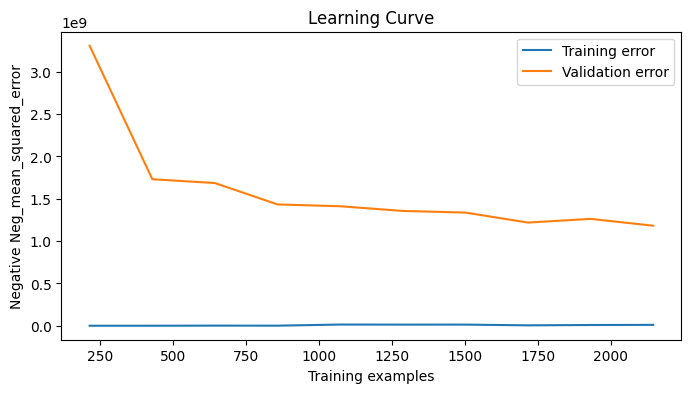

In [68]:
# XGBoost
xgb = XGBRegressor()
xgb_params = {
    'learning_rate': [0.2, 0.3, 0.4, 0.5],
    'max_depth': np.arange(2, 10, step=1),
    'min_child_weight': np.arange(2, 10, step=1),
    'gamma': np.arange(0, 10, step=1),
}

xgb_model, xgb_train_sizes, xgb_train_scores, xgb_test_scores = perform_search(xgb, xgb_params, X_train, y_train, X_test, y_test)
xgb_feature_importances = xgb_model.feature_importances_

plot_learning_curve(xgb_model, X_train, y_train, cv=tscv)

In [69]:
# XGBOOST:
# Best hyperparameters are: {'min_child_weight': 2, 'max_depth': 9, 'learning_rate': 0.3, 'gamma': 1}
# Best score is: -0.5292068443419465
# MSE: 449867017.4165748
# MAE: 4859.57753647512
# MAPE: 0.36346876707990555

Best hyperparameters are: {'gamma': 0, 'learning_rate': 0.3, 'max_depth': 9, 'min_child_weight': 2}
Best score is: -0.5292068443419465
MSE: 449867017.4165748
MAE: 4859.57753647512
MAPE: 0.36346876707990555


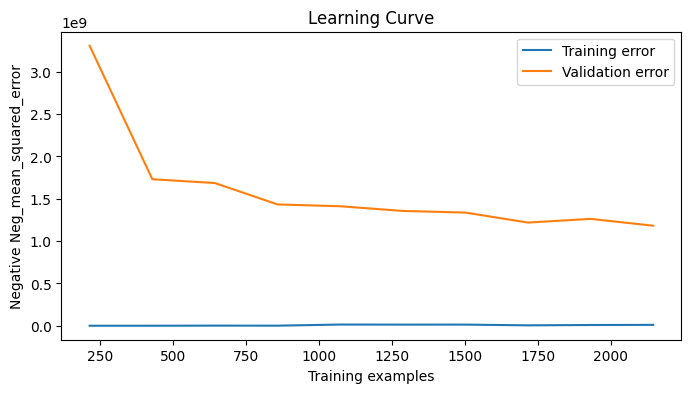

In [70]:
# XGBoost: gridsearchcv
xgb = XGBRegressor()
xgb_grid_params = {
    'learning_rate': [0.2, 0.3, 0.4, 0.5],
    'max_depth': np.arange(2, 10, step=1),
    'min_child_weight': np.arange(2, 10, step=1),
    'gamma': np.arange(0, 10, step=1),
}

xgb_grid_model, xgb_grid_train_sizes, xgb_grid_train_scores, xgb_grid_test_scores = perform_search(xgb, xgb_grid_params, X_train, y_train, X_test, y_test, search_type='grid')
xgb_grid_feature_importances = xgb_grid_model.feature_importances_

plot_learning_curve(xgb_grid_model, X_train, y_train, cv=tscv)


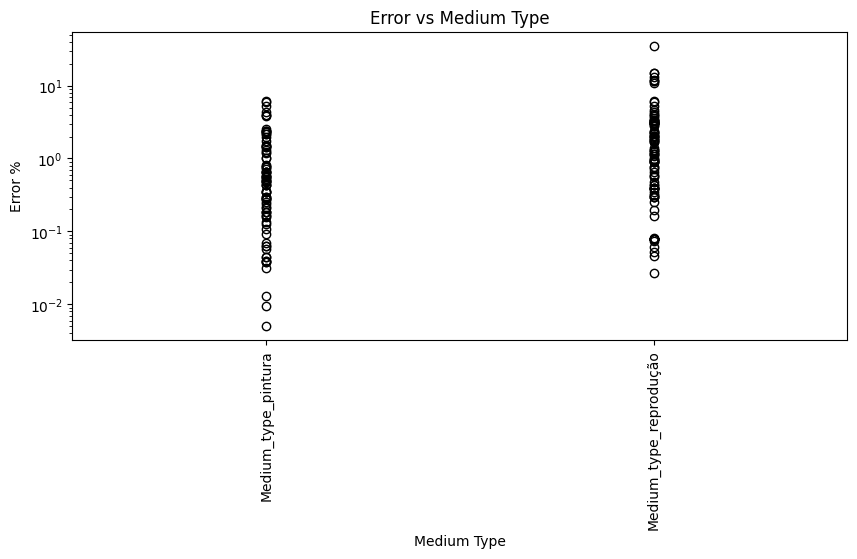

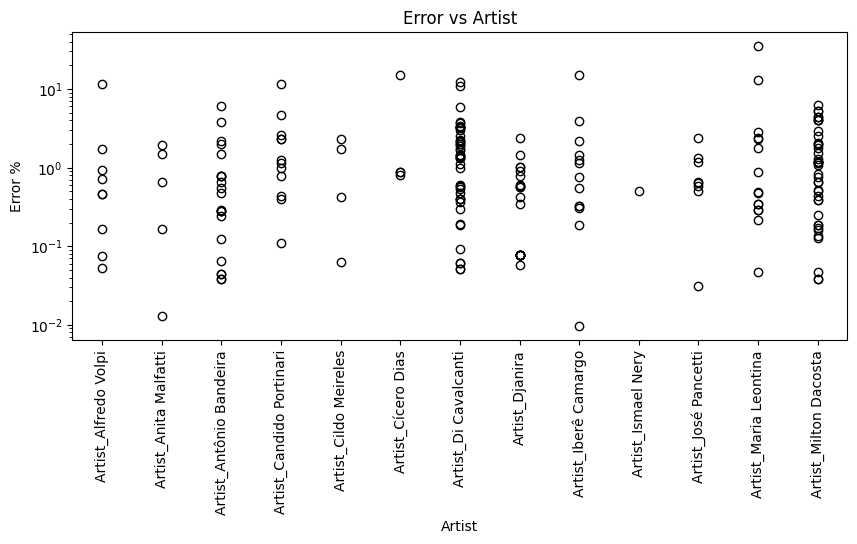

In [71]:
lots_copy = models_utils.get_predicted_price_and_error(X_test, y_test, xgb_model)
medium_types = ['Medium_type_pintura', 'Medium_type_reprodução'] #, 'desenho']
artists = lots_copy.columns[1:-10]

models_utils.plot_error_by_columns(lots_copy, medium_types, 'Medium Type')
models_utils.plot_error_by_columns(lots_copy, artists, 'Artist')

<Axes: xlabel='Actual Price', ylabel='Predicted Price'>

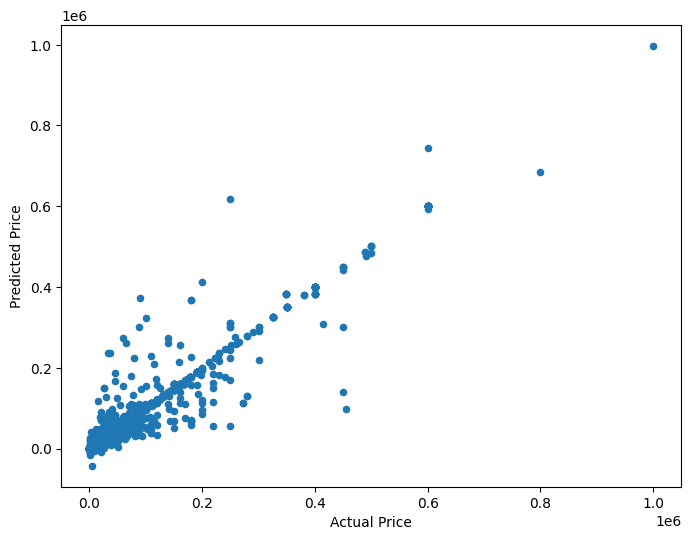

In [78]:
# plot actual price vs predicted price
lots_copy.plot.scatter(x='Actual Price', y='Predicted Price', figsize=(8, 6))

In [73]:
lots_copy.sort_values(by='Error %', ascending=False, inplace=True)
lots_copy.head(10)

,Artist_Aldemir Martins,Artist_Alfredo Volpi,Artist_Anita Malfatti,Artist_Antônio Bandeira,Artist_Candido Portinari,Artist_Cildo Meireles,Artist_Cícero Dias,Artist_Di Cavalcanti,Artist_Djanira,Artist_Iberê Camargo,...,Artist_Tarsila do Amaral,Height (cm),Medium_type_pintura,Medium_type_reprodução,Width (cm),Year of sale,Predicted Price,Actual Price,Error,Error %
Year,,,,,,,,,,,,,,,,,,,,,
NaN,False,False,False,False,False,False,False,False,False,False,...,False,23.0,False,True,17.0,2008,3703.300049,100.0,3603.300049,35.033000
1991.0,False,False,False,False,False,False,False,False,False,True,...,False,34.5,False,True,39.5,2005,20487.298828,1200.0,19287.298828,15.072749
2003,False,False,False,False,False,False,True,False,False,False,...,False,58.0,False,True,46.0,2022,25452.369141,1500.0,23952.369141,14.968246
NaN,False,False,False,False,False,False,False,False,False,False,...,False,26.0,False,True,27.5,2017,2241.035400,150.0,2091.035400,12.940236
NaN,False,False,False,False,False,False,False,True,False,False,...,False,54.0,False,True,66.0,2013,14103.566406,1000.0,13103.566406,12.103566
NaN,False,False,False,False,True,False,False,False,False,False,...,False,109.0,False,True,127.0,2013,40563.980469,3000.0,37563.980469,11.521327
NaN,False,True,False,False,False,False,False,False,False,False,...,False,66.0,False,True,96.0,2020,20108.158203,1500.0,18608.158203,11.405439
NaN,False,False,False,False,False,False,False,True,False,False,...,False,37.0,False,True,55.0,2017,8987.023438,700.0,8287.023438,10.838605
1996,True,False,False,False,False,False,False,False,False,False,...,False,35.0,False,True,50.0,2014,2880.373291,350.0,2530.373291,6.229638


In [74]:
# save xgb model as pickle file
pickle.dump(xgb_model, open('./models/catalogo_xgb_model.pkl', 'wb'))
# save x_test as csv
X_test.to_csv('./models/catalogo_X_test.csv', index=False)

In [75]:
## ENSEMBLE MODEL

pred_xgb = xgb_model.predict(X_test)
pred_rf = rf_model.predict(X_test)

weight_rf = 0
ensemble_df = pd.DataFrame(columns=['MSE', 'MAE', 'MAPE', 'Weight XGB', 'Weight RF'])
for i in range(0,10):
    weight_xgb = 1 - weight_rf
    
    final_pred = (weight_xgb * pred_xgb) + (weight_rf * pred_rf)
    
    ensemble_mse = mean_squared_error(y_test, final_pred)
    ensemble_mae = mean_absolute_error(y_test, final_pred)
    ensemble_mape = mean_absolute_percentage_error(y_test, final_pred)

    # store mse, mae and weights in a dataframe 
    ensemble_df.loc[i] = [f'{ensemble_mse:.2f}', ensemble_mae, ensemble_mape, weight_xgb, weight_rf]

    weight_rf += 0.1
    

ensemble_df.sort_values(by='MAPE', ascending=True, inplace=True)
ensemble_df

,MSE,MAE,MAPE,Weight XGB,Weight RF
1,439350863.65,5235.662144,0.362194,0.9,0.1
0,449867017.42,4859.577536,0.363469,1.0,0.0
2,436932379.32,5696.945686,0.365383,0.8,0.2
3,442611526.75,6173.182379,0.370563,0.7,0.3
4,456388340.85,6679.171278,0.377285,0.6,0.4
5,478262785.09,7201.806768,0.387976,0.5,0.5
6,508234881.24,7745.426526,0.401852,0.4,0.6
7,546304632.65,8303.943231,0.418345,0.3,0.7
8,592472025.13,8886.264448,0.437839,0.2,0.8
9,646737070.31,9476.586147,0.460571,0.1,0.9
